# Synthetic Example

This notebook includes independent codes for training diffusion path sampler to sample transition paths of a synthetic double-well system. We evaluate the realisticity and diversity of our model both quantitatively and qualitatively.

#### Imports

In [1]:
import torch
import numpy as np
from torch import nn
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

/home/guest_sky/.conda/envs/tps-dps/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### System Configurations

In [2]:
seed = 7
device = "cuda" if torch.cuda.is_available() else "cpu"

#### Sampling Configurations

In [3]:
sigma = 3
num_steps = 1000
timestep = 0.01
num_samples = 512
temperature = 1200
kB = 8.6173303e-5
std = np.sqrt(2 * kB * temperature * timestep)
log_prob = torch.distributions.Normal(0, std).log_prob
start_position = torch.tensor([-1.118, 0], dtype=torch.float32).to(device)
target_position = torch.tensor([1.118, 0], dtype=torch.float32).to(device)

#### Training Configuration


In [4]:
log_z_lr = 0.001
policy_lr = 0.0001
batch_size = 512
num_rollouts = 20
max_grad_norm = 1
buffer_size = 10000
trains_per_rollout = 300
start_temperature = 2400
end_temperature = 1200

temperatures = torch.linspace(
    start_temperature, end_temperature, num_rollouts
)
stds = torch.sqrt(2 * kB * timestep * temperatures)

#### Synthetic System

In [5]:
def system(pos):
    pos.requires_grad_(True)
    x = pos[:, 0]
    y = pos[:, 1]
    term_1 = 4 * (1 - x**2 - y**2) ** 2
    term_2 = 2 * (x**2 - 2) ** 2
    term_3 = ((x + y) ** 2 - 1) ** 2
    term_4 = ((x - y) ** 2 - 1) ** 2
    potential = (term_1 + term_2 + term_3 + term_4 - 2.0) / 6.0
    force = -torch.autograd.grad(potential.sum(), pos)[0]
    pos.requires_grad_(False)
    return force, potential.detach()

#### Bias force

In [6]:
class BiasForce(nn.Module):
    def __init__(self):
        super().__init__()

        self.input_dim = 3
        self.output_dim = 1

        self.mlp = nn.Sequential(
            nn.Linear(self.input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, self.output_dim, bias=False),
        )

        self.log_z = nn.Parameter(torch.tensor(0.0))

        self.to(device)

    def forward(self, pos):
        pos.requires_grad = True
        
        dist = torch.norm(pos - target_position, dim=-1, keepdim=True)
        input = torch.cat([pos, dist], dim=-1)
        output = self.mlp(input.reshape(-1, self.input_dim))

        force = -torch.autograd.grad(
            output.sum(), pos, create_graph=True, retain_graph=True
        )[0]
        return force

#### Diffusion path sampler

In [7]:
class DiffusionPathSampler:
    def __init__(self):
        self.policy = BiasForce()
        self.target_measure = TargetMeasure()
        self.replay = ReplayBuffer()

    def sample(self, std):
        positions = torch.zeros(
            (num_samples, num_steps + 1, 2),
            device=device,
        )
        forces = torch.zeros(
            (num_samples, num_steps + 1, 2),
            device=device,
        )
        noises = torch.normal(
            torch.zeros(
                (num_samples, num_steps, 2),
                device=device,
            ),
            torch.ones(
                (num_samples, num_steps, 2),
                device=device,
            ),
        )
        potentials = torch.zeros(num_samples, num_steps + 1, device=device)

        position = start_position.unsqueeze(0)
        force, potential = system(position)
        positions[:, 0] = position
        forces[:, 0] = force
        potentials[:, 0] = potential

        for s in tqdm(range(num_steps), desc="Sampling"):
            bias = (
                self.policy(position.detach()).squeeze().detach()
            )
            position = position + (force + bias) * timestep + std * noises[:, s]
            force, potential = system(position)

            positions[:, s + 1] = position
            forces[:, s + 1] = force
            potentials[:, s + 1] = potential

        log_tm, final_idx = self.target_measure(positions, forces)

        self.replay.add((positions, forces, log_tm))

        trunc_positions = []
        trunc_potentials = []
        for i in range(num_samples):
            trunc_positions.append(positions[i][: final_idx[i] + 1])
            trunc_potentials.append(potentials[i][: final_idx[i] + 1])

        return trunc_positions, trunc_potentials

    def train(self):
        optimizer = torch.optim.Adam(
            [
                {"params": [self.policy.log_z], "lr": log_z_lr},
                {"params": self.policy.mlp.parameters(), "lr": policy_lr},
            ]
        )

        loss_sum = 0
        for _ in tqdm(range(trains_per_rollout), desc="Training"):

            positions, forces, log_tm = self.replay.sample()
            biases = self.policy(positions)
            means = positions + (forces + biases) * timestep
            log_bpm = log_prob(positions[:, 1:] - means[:, :-1]).mean((1, 2))

            # Our implementation is based on results in appendix A.2
            log_z = self.policy.log_z
            loss = (log_z + log_bpm - log_tm).square().mean()
            loss.backward()

            for group in optimizer.param_groups:
                torch.nn.utils.clip_grad_norm_(group["params"], max_grad_norm)

            optimizer.step()
            optimizer.zero_grad()

            loss_sum += loss.item()
        loss = loss_sum / trains_per_rollout
        return loss


class ReplayBuffer:
    def __init__(self):
        self.positions = torch.zeros(
            (buffer_size, num_steps + 1, 2),
            device=device,
        )
        self.forces = torch.zeros(
            (buffer_size, num_steps + 1, 2),
            device=device,
        )
        self.log_reward = torch.zeros(buffer_size, device=device)

        self.idx = 0

    def add(self, data):
        indices = torch.arange(self.idx, self.idx + num_samples) % buffer_size
        self.idx += num_samples

        (
            self.positions[indices],
            self.forces[indices],
            self.log_reward[indices],
        ) = data

    def sample(self):
        indices = torch.randint(0, min(self.idx, buffer_size), (batch_size,))
        return (
            self.positions[indices],
            self.forces[indices],
            self.log_reward[indices],
        )


class TargetMeasure:
    def __init__(self):
        pass

    def __call__(self, positions, forces):
        log_upm = self.unbiased_path_measure(positions, forces)
        log_ri, final_idx = self.relaxed_indicator(positions, target_position)

        log_reward = log_upm + log_ri
        return log_reward, final_idx

    def unbiased_path_measure(self, positions, forces):
        means = positions + forces * timestep
        log_upm = log_prob(positions[:, 1:] - means[:, :-1]).mean((1, 2))
        return log_upm

    def relaxed_indicator(self, positions, target_position):
        log_ri, final_idx = (
            self.rbf(
                positions.view(-1, positions.size(-1)),
                target_position,
            )
            .view(positions.size(0), positions.size(1))
            .max(1)
        )
        return log_ri, final_idx

    def rbf(self, positions, target_position):
        msd = (positions - target_position).square().mean(-1)
        log_ri = -0.5 / sigma**2 * msd
        return log_ri


#### Metrics and Plots

In [8]:
def print_metric(log):
    print(
        f"RMSD: {format_value(log['rmsd'], log['rmsd_std'])} & "
        f"THP: {format_value(log['thp'])} & "
        f"ETS: {format_value(log['ets'], log['ets_std'])}"
    )

def format_value(value, std_value=None):
    if value is None:
        return "-"
    if std_value is None:
        return f"{value:.2f}"
    return f"{value:.2f}±{std_value:.2f}"


class Metric:
    def __call__(self, positions, potentials):
        final_position = torch.stack([position[-1] for position in positions])
        rmsd_mean, rmsd_std = self.rmsd(final_position, target_position)
        thp, hit = self.thp(final_position, target_position)
        etss, ys, ets_mean, ets_std = self.ets(hit, positions, potentials)

        metrics = {
            "rmsd": rmsd_mean,
            "thp": thp,
            "ets": ets_mean,
            "rmsd_std": rmsd_std,
            "ets_std": ets_std,
        }
        self.paths(positions[:64])
        self.distribution(etss, ys)
        return metrics

    def rmsd(self, final_position, target_position):
        rmsd = (final_position - target_position).square().sum(-1).sqrt()
        mean_rmsd, std_rmsd = rmsd.mean().item(), rmsd.std().item()
        return mean_rmsd, std_rmsd

    def thp(self, final_position, target_position):
        hit = (final_position - target_position).square().sum(-1).sqrt() < 0.5
        thp = 100 * hit.sum().float() / len(hit)
        return thp.item(), hit

    def ets(self, hit, positions, potentials):
        etss = []
        ys = []
        mean_ets, std_ets = None, None
        for i, hit_idx in enumerate(hit):
            if hit_idx:
                ets, idx = potentials[i].max(0)
                etss.append(ets)
                ys.append(positions[i][idx][1].item())

        if len(etss) > 0:
            etss = torch.tensor(etss)
            mean_ets, std_ets = etss.mean().item(), etss.std().item()

        return etss, ys, mean_ets, std_ets

    def paths(self, positions):
        ax = plt.subplots(figsize=(7, 7))[1]

        zorder = 100
        circle_size = 1200
        saddle_size = 2400

        plt.xlim(-1.5, 1.5)
        plt.ylim(-1.5, 1.5)
        x = np.linspace(-1.5, 1.5, 400)
        y = np.linspace(-1.5, 1.5, 400)
        X, Y = np.meshgrid(x, y)

        term_1 = 4 * (1 - X**2 - Y**2) ** 2
        term_2 = 2 * (X**2 - 2) ** 2
        term_3 = ((X + Y) ** 2 - 1) ** 2
        term_4 = ((X - Y) ** 2 - 1) ** 2
        Z = (term_1 + term_2 + term_3 + term_4 - 2.0) / 6.0

        ax.contourf(X, Y, Z, levels=zorder, zorder=0, vmax=3)

        cm = plt.get_cmap("gist_rainbow")

        ax.set_prop_cycle(
            color=[cm(1.0 * i / len(positions)) for i in range(len(positions))]
        )

        for position in positions:
            xs = position[:, 0].detach().cpu().numpy()
            ys = position[:, 1].detach().cpu().numpy()
            ax.plot(
                xs,
                ys,
                marker="o",
                linestyle="None",
                markersize=2,
                alpha=1.0,
                zorder=zorder - 1,
            )

        # Plot start and end positions
        ax.scatter(
            [start_position[0].item()],
            [start_position[1].item()],
            edgecolors="black",
            c="w",
            zorder=zorder,
            s=circle_size,
        )
        ax.scatter(
            [target_position[0].item()],
            [target_position[1].item()],
            edgecolors="black",
            c="w",
            zorder=zorder,
            s=circle_size,
        )

        saddle_points = [(0, 1), (0, -1)]
        for saddle in saddle_points:
            ax.scatter(
                saddle[0],
                saddle[1],
                edgecolors="black",
                c="w",
                zorder=zorder,
                s=saddle_size,
                marker="*",
            )

        # Plot basic configs
        ax.set_xlabel("x", fontsize=24, fontweight="medium")
        ax.set_ylabel("y", fontsize=24, fontweight="medium")
        plt.tick_params(
            left=False,
            right=False,
            labelleft=False,
            labelbottom=False,
            bottom=False,
        )
        plt.tight_layout()
        plt.show()
        plt.close()

    def distribution(self, etss, ys):
        axs = plt.subplots(1, 2, figsize=(6, 3))[1]

        kde = gaussian_kde(etss)
        x = np.linspace(min(etss), max(etss), 1000)
        y = kde(x)
        axs[0].fill_between(x, y, alpha=0.1)
        axs[0].plot(x, y)
        axs[0].set_xlabel("Energy (kJ/mol)", fontsize=14, fontweight="medium")
        axs[0].set_ylabel("")
        axs[0].set_xlim([1, 2.5])

        kde = gaussian_kde(ys)
        x = np.linspace(min(ys), max(ys), 1000)
        y = kde(x)
        axs[1].fill_between(x, y, alpha=0.1)
        axs[1].plot(x, y)
        axs[1].set_xlabel("y", fontsize=14, fontweight="medium")
        axs[1].set_ylabel("")
        axs[1].set_xlim([-2, 2])

        for ax in axs:
            ax.tick_params(
                left=False,
                right=False,
                labelleft=False,
                labelbottom=True,
                bottom=True,
                labelsize=10,
            )

        # set overall plot title: distribution of transition states
        plt.suptitle("Distributions of Transition States", fontsize=14)
        plt.tight_layout()
        plt.show()
        plt.close()

### Training

Training: 100%|██████████| 300/300 [00:02<00:00, 137.81it/s]


Rollout: 0, Loss: 0.000910


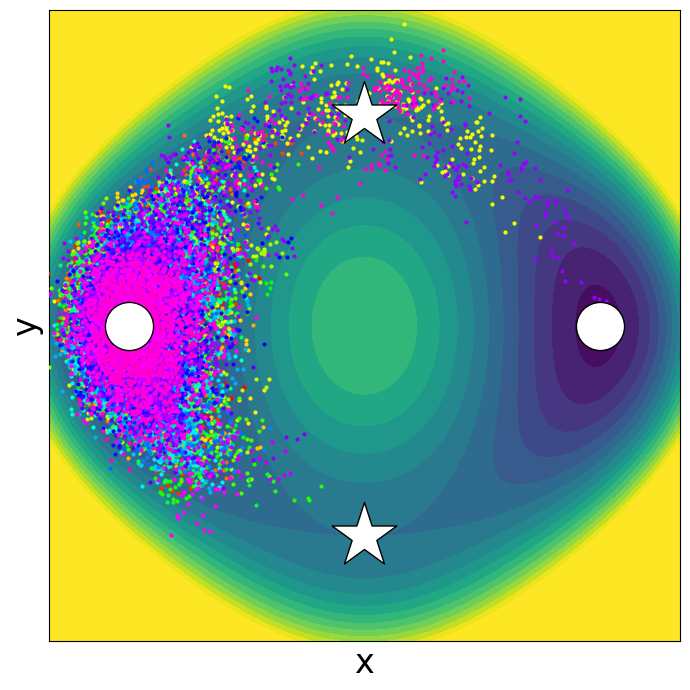

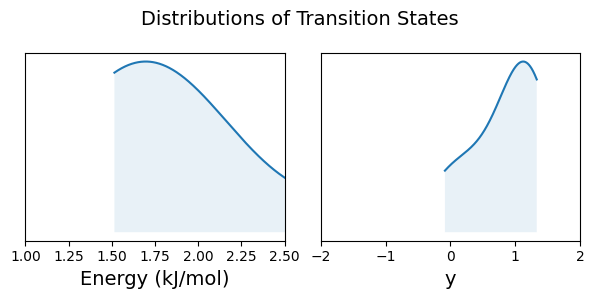

RMSD: 1.68±0.24 & THP: 1.17 & ETS: 1.96±0.66


Training: 100%|██████████| 300/300 [00:02<00:00, 137.79it/s]


Rollout: 1, Loss: 0.000294


Training: 100%|██████████| 300/300 [00:02<00:00, 137.48it/s]


Rollout: 2, Loss: 0.000363


Training: 100%|██████████| 300/300 [00:02<00:00, 137.74it/s]


Rollout: 3, Loss: 0.000414


Training: 100%|██████████| 300/300 [00:02<00:00, 137.19it/s]


Rollout: 4, Loss: 0.000461


Training: 100%|██████████| 300/300 [00:02<00:00, 137.65it/s]


Rollout: 5, Loss: 0.000558


Training: 100%|██████████| 300/300 [00:02<00:00, 137.24it/s]


Rollout: 6, Loss: 0.000679


Training: 100%|██████████| 300/300 [00:02<00:00, 136.80it/s]


Rollout: 7, Loss: 0.000637


Training: 100%|██████████| 300/300 [00:02<00:00, 137.25it/s]


Rollout: 8, Loss: 0.000426


Training: 100%|██████████| 300/300 [00:02<00:00, 136.98it/s]


Rollout: 9, Loss: 0.000273


Training: 100%|██████████| 300/300 [00:02<00:00, 137.68it/s]


Rollout: 10, Loss: 0.000225


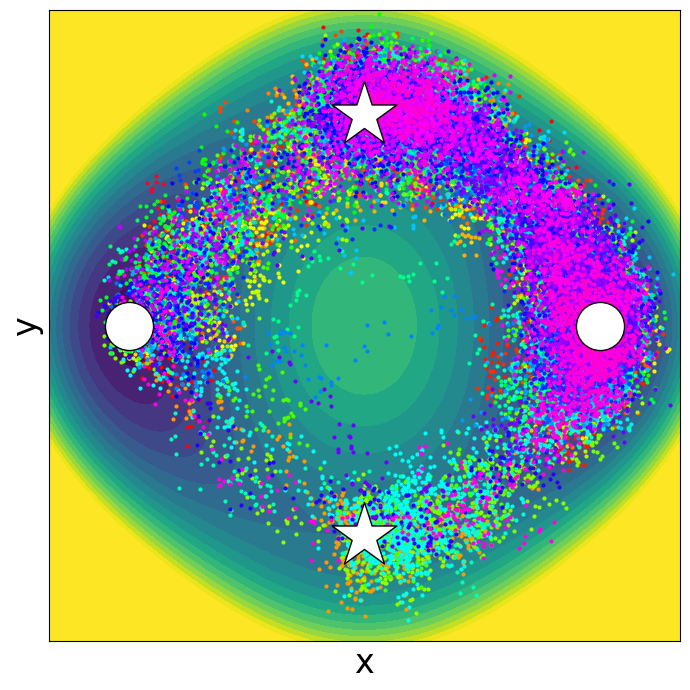

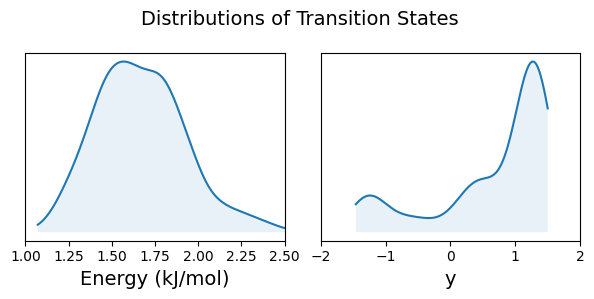

RMSD: 0.04±0.14 & THP: 97.46 & ETS: 1.67±0.26


Training: 100%|██████████| 300/300 [00:02<00:00, 138.11it/s]


Rollout: 11, Loss: 0.000211


Training: 100%|██████████| 300/300 [00:02<00:00, 137.78it/s]


Rollout: 12, Loss: 0.000201


Training: 100%|██████████| 300/300 [00:02<00:00, 138.15it/s]


Rollout: 13, Loss: 0.000193


Training: 100%|██████████| 300/300 [00:02<00:00, 137.43it/s]


Rollout: 14, Loss: 0.000179


Training: 100%|██████████| 300/300 [00:02<00:00, 137.92it/s]


Rollout: 15, Loss: 0.000160


Training: 100%|██████████| 300/300 [00:02<00:00, 137.61it/s]


Rollout: 16, Loss: 0.000148


Training: 100%|██████████| 300/300 [00:02<00:00, 137.35it/s]


Rollout: 17, Loss: 0.000141


Training: 100%|██████████| 300/300 [00:02<00:00, 137.61it/s]


Rollout: 18, Loss: 0.000130


Training: 100%|██████████| 300/300 [00:02<00:00, 137.34it/s]


Rollout: 19, Loss: 0.000118


Sampling: 100%|██████████| 1000/1000 [00:01<00:00, 521.96it/s]


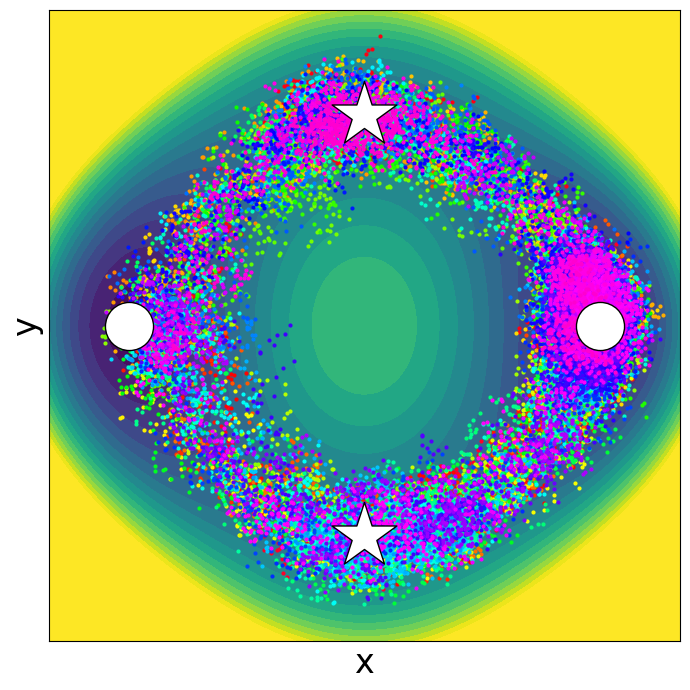

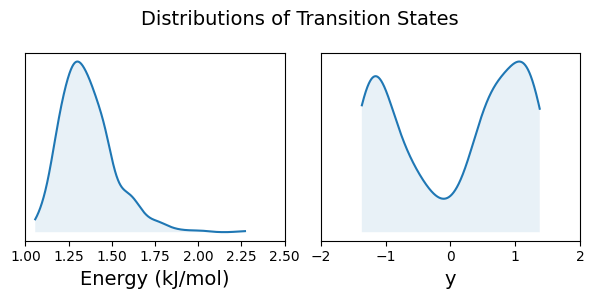

RMSD: 0.01±0.00 & THP: 100.00 & ETS: 1.36±0.16


In [9]:
torch.manual_seed(seed)

agent = DiffusionPathSampler()
metric = Metric()

for rollout in range(num_rollouts):
    data = agent.sample(stds[rollout])
    loss = agent.train()
    print(f"Rollout: {rollout}, Loss: {loss:.6f}")
    if rollout % 10 == 0:
        print_metric(metric(*data))

log = metric(*agent.sample(std))
print_metric(log)